# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-25000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/transformer_25000'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define Transformer based auto-encoder

- Split 64 * 64 image into 8 * 8 patches (total 8 * 8 = 64 blocks)
- Every block have input length of 8 * 8 * 3 = 192 dimension
- Project the patch into 256 dimension embedding
- Add Positional Encoding to it
- Go through 4 layer of 8 heads transformers with 512 MLP dimension

And the decoder works reversely.

In [2]:
import math

# Define the positional encoding
class PositionalEncoding2D(nn.Module):
    def __init__(self, dim, image_size, patch_size):
        super(PositionalEncoding2D, self).__init__()
        self.encoding = nn.Parameter(self.create_positional_encoding(dim, image_size, patch_size), requires_grad=False)

    def create_positional_encoding(self, dim, image_size, patch_size):
        num_patches = (image_size // patch_size) ** 2
        encoding = torch.zeros(num_patches, dim)
        position = torch.arange(0, num_patches, dtype=torch.float).unsqueeze(1)
        
        # Calculate row and column positions
        row_pos = position // (image_size // patch_size)
        col_pos = position % (image_size // patch_size)
        
        div_term = torch.exp(torch.arange(0, dim, 4).float() * (-math.log(10000.0) / dim))
        
        encoding[:, 0::4] = torch.sin(row_pos * div_term)
        encoding[:, 1::4] = torch.cos(row_pos * div_term)
        encoding[:, 2::4] = torch.sin(col_pos * div_term)
        encoding[:, 3::4] = torch.cos(col_pos * div_term)
        
        return encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding

# Define the Vision Transformer autoencoder model
class TransformerAutoencoder(nn.Module):
    def __init__(self, image_size=64, patch_size=8, dim=128, depth=4, heads=8, mlp_dim=1024, bottleneck_dim=32, dropout_rate=0.1):
        super(TransformerAutoencoder, self).__init__()
        self.patch_size = patch_size
        self.dim = dim
        self.bottleneck_dim = bottleneck_dim
        self.num_patches = (image_size // patch_size) ** 2
        self.flatten_dim = patch_size * patch_size * 3

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads, 
            batch_first=True,
            dim_feedforward=mlp_dim,
            dropout=dropout_rate
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.patch_embedding = nn.Linear(self.flatten_dim, dim)
        self.positional_encoding = PositionalEncoding2D(dim, image_size, patch_size)
        self.bottleneck = nn.Linear(dim * self.num_patches, bottleneck_dim)
        self.decoder_input = nn.Linear(bottleneck_dim, dim * self.num_patches)

        # Define the decoder as a transformer encoder
        decoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads, 
            batch_first=True,
            dim_feedforward=mlp_dim,
            dropout=dropout_rate
        )
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=depth)

        self.output_layer = nn.Linear(dim, self.flatten_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Divide the image into patches
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(x.size(0), -1, self.flatten_dim)

        # Embed patches and add positional encoding
        x = self.patch_embedding(x)
        x = self.positional_encoding(x)

        # Transformer encoding
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        encoded = self.bottleneck(x)

        # Transformer decoding
        x = self.decoder_input(encoded)
        x = x.view(x.size(0), -1, self.dim)
        x = self.decoder(x)

        # Reshape back to image
        # Output layer to reshape back to image
        x = self.output_layer(x)
        x = self.sigmoid(x)
        x = x.view(x.size(0), 3, 64, 64)
        return x, encoded

In [3]:
from util import train_model_steps, plot_model, count_parameters, calculate_metrics, save_to_file, load_from_file, print_matrix, plot_conf_matrix

def train_model(patch_size=8, dim=128, depth=4, heads=8, mlp_dim=256, embedding_size=32, dropout_rate=0.1, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = TransformerAutoencoder(
        patch_size=patch_size,
        dim=dim,
        depth=depth, 
        heads=heads,
        mlp_dim=mlp_dim,
        bottleneck_dim=embedding_size, 
        dropout_rate=dropout_rate
    )
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}p{patch_size}d{dim}dp{depth}h{heads}m{mlp_dim}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}p{patch_size}d{dim}dp{depth}h{heads}m{mlp_dim}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    metrics = calculate_metrics(model, testset)
    print_matrix(metrics)
    plot_conf_matrix(metrics['conf_matrix'])
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from dim = 512)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 1183044
Epoch [1/20], Train Loss: 0.2305, Test Loss: 0.1794
Epoch [2/20], Train Loss: 0.1749, Test Loss: 0.1742
Epoch [3/20], Train Loss: 0.1699, Test Loss: 0.1636
Epoch [4/20], Train Loss: 0.1544, Test Loss: 0.1475
Epoch [5/20], Train Loss: 0.1315, Test Loss: 0.1250
Epoch [6/20], Train Loss: 0.1224, Test Loss: 0.1208
Epoch [7/20], Train Loss: 0.1179, Test Loss: 0.1200
Epoch [8/20], Train Loss: 0.1145, Test Loss: 0.1153
Epoch [9/20], Train Loss: 0.1114, Test Loss: 0.1138
Epoch [10/20], Train Loss: 0.1088, Test Loss: 0.1085
Epoch [11/20], Train Loss: 0.1069, Test Loss: 0.1095
Epoch [12/20], Train Loss: 0.1057, Test Loss: 0.1067
Epoch [13/20], Train Loss: 0.1046, Test Loss: 0.1060
Epoch [14/20], Train Loss: 0.1036, Test Loss: 0.1035
Epoch [15/20], Train Loss: 0.1026, Test Loss: 0.1038
Epoch [16/20], Train Loss: 0.1024, Test Loss: 0.1025
Epoch [17/20], Train Loss: 0.1020, Test Loss: 0.1030
Epoch [18/20], Train Loss: 0.1016, Test Loss: 0.1020
Epoch [19/20], Train Loss

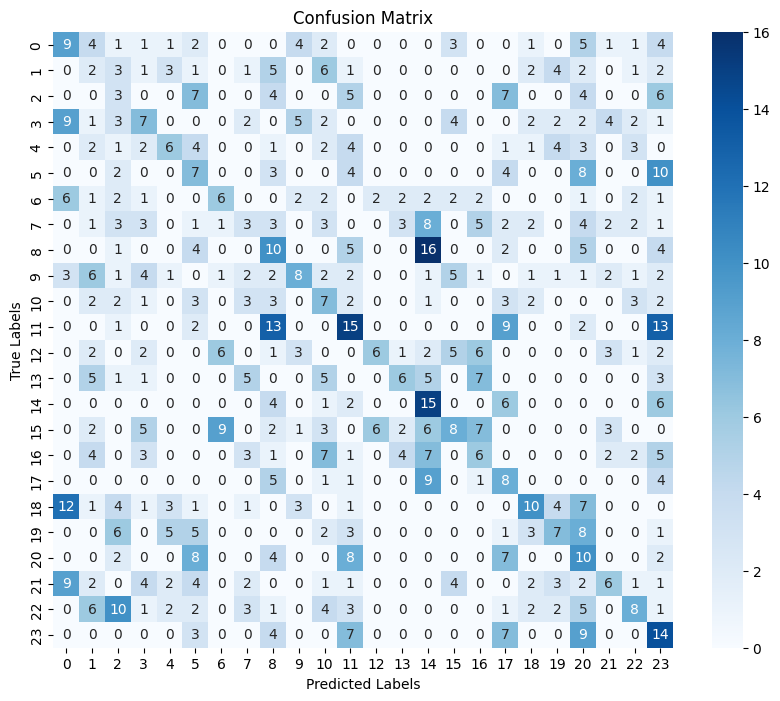

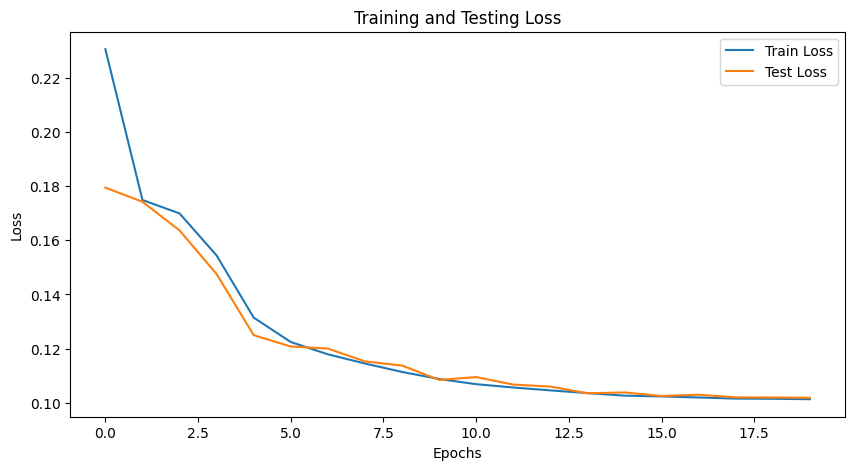

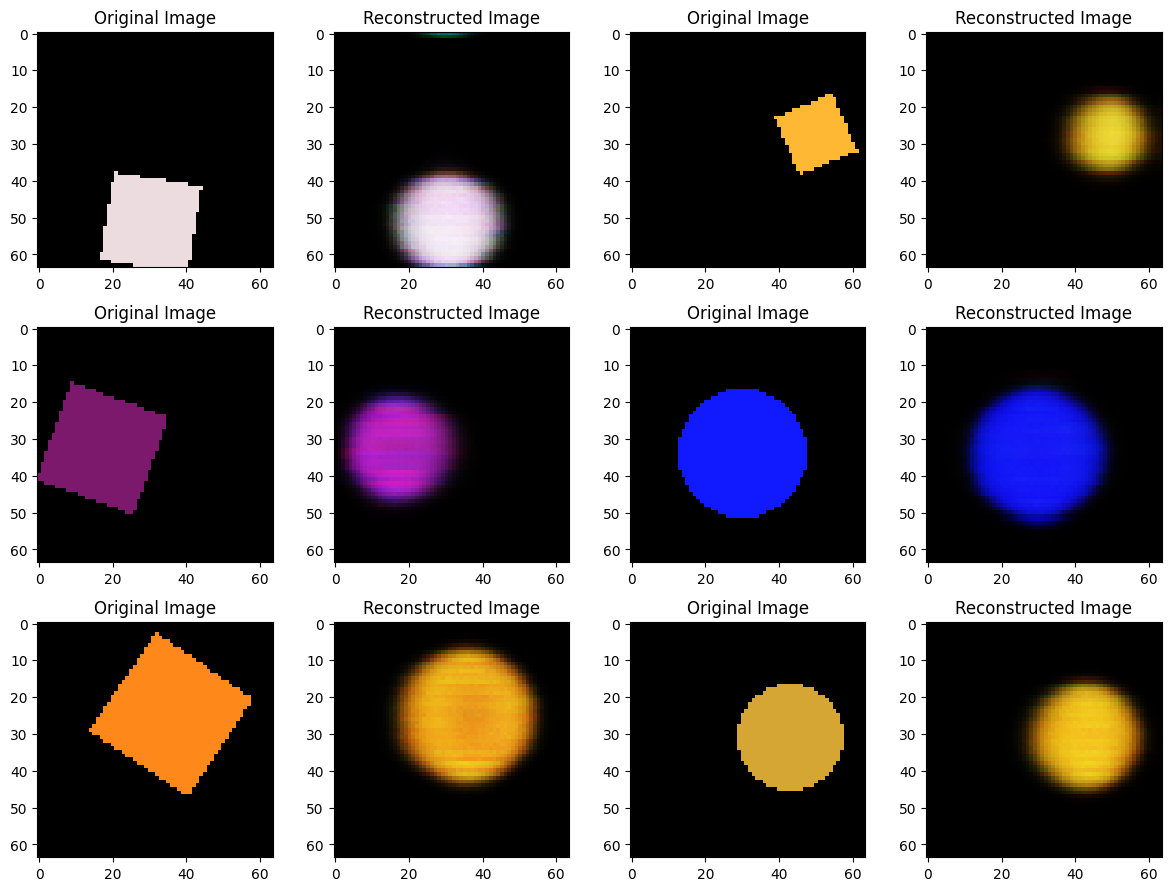

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (linear1): Linear(in_features=128, out_features=256, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=256, out_features=128, bias=True)
         (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=8192, out_features=4, bias=True)
   (decoder_input): Linear(in_features=4, out_features=8192, 

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 1248584
Epoch [1/20], Train Loss: 0.2170, Test Loss: 0.1661
Epoch [2/20], Train Loss: 0.1627, Test Loss: 0.1607
Epoch [3/20], Train Loss: 0.1406, Test Loss: 0.1195
Epoch [4/20], Train Loss: 0.1109, Test Loss: 0.1049
Epoch [5/20], Train Loss: 0.1022, Test Loss: 0.0999
Epoch [6/20], Train Loss: 0.0981, Test Loss: 0.0975
Epoch [7/20], Train Loss: 0.0957, Test Loss: 0.0948
Epoch [8/20], Train Loss: 0.0940, Test Loss: 0.0938
Epoch [9/20], Train Loss: 0.0927, Test Loss: 0.0925
Epoch [10/20], Train Loss: 0.0917, Test Loss: 0.0920
Epoch [11/20], Train Loss: 0.0909, Test Loss: 0.0916
Epoch [12/20], Train Loss: 0.0903, Test Loss: 0.0908
Epoch [13/20], Train Loss: 0.0898, Test Loss: 0.0910
Epoch [14/20], Train Loss: 0.0894, Test Loss: 0.0903
Epoch [15/20], Train Loss: 0.0891, Test Loss: 0.0903
Epoch [16/20], Train Loss: 0.0888, Test Loss: 0.0898
Epoch [17/20], Train Loss: 0.0887, Test Loss: 0.0896
Epoch [18/20], Train Loss: 0.0885, Test Loss: 0.0896
Epoch [19/20], Train Loss

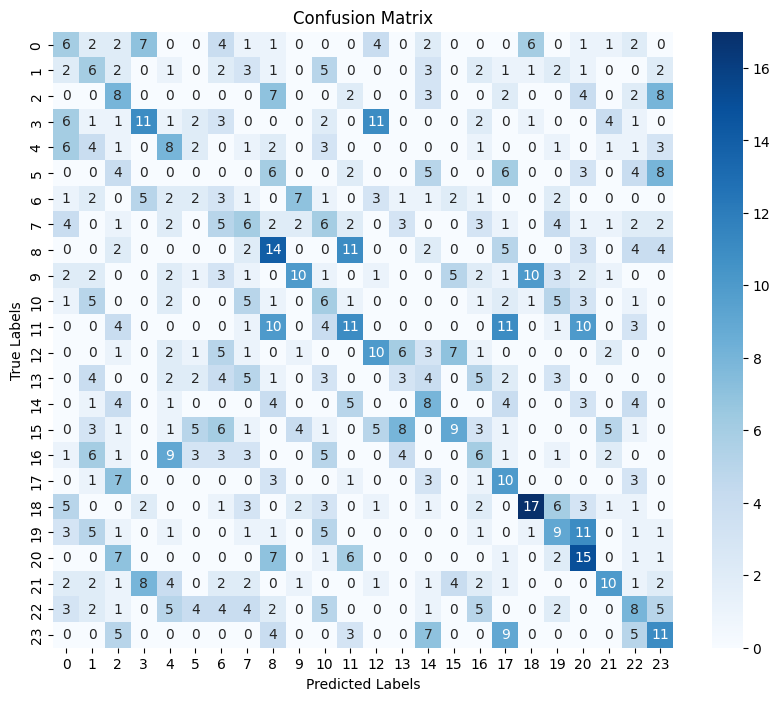

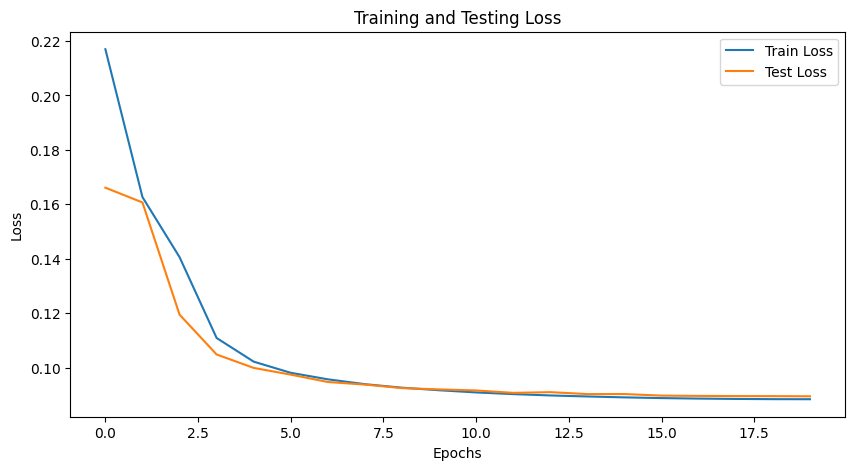

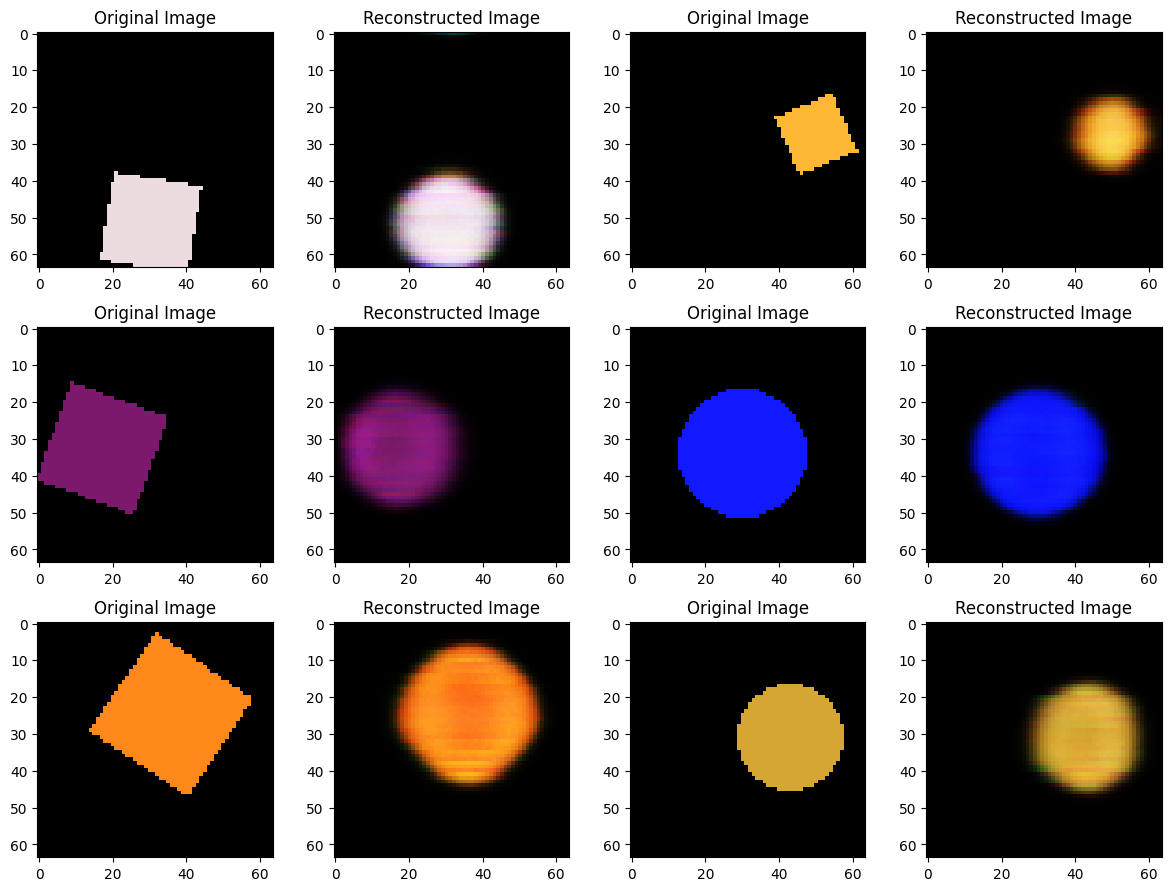

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (linear1): Linear(in_features=128, out_features=256, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=256, out_features=128, bias=True)
         (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=8192, out_features=8, bias=True)
   (decoder_input): Linear(in_features=8, out_features=8192, 

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 1379664
Epoch [1/20], Train Loss: 0.2108, Test Loss: 0.1641
Epoch [2/20], Train Loss: 0.1589, Test Loss: 0.1470
Epoch [3/20], Train Loss: 0.1271, Test Loss: 0.1109
Epoch [4/20], Train Loss: 0.1053, Test Loss: 0.1020
Epoch [5/20], Train Loss: 0.0992, Test Loss: 0.0976
Epoch [6/20], Train Loss: 0.0954, Test Loss: 0.0947
Epoch [7/20], Train Loss: 0.0931, Test Loss: 0.0943
Epoch [8/20], Train Loss: 0.0916, Test Loss: 0.0917
Epoch [9/20], Train Loss: 0.0904, Test Loss: 0.0914
Epoch [10/20], Train Loss: 0.0894, Test Loss: 0.0901
Epoch [11/20], Train Loss: 0.0886, Test Loss: 0.0896
Epoch [12/20], Train Loss: 0.0880, Test Loss: 0.0891
Epoch [13/20], Train Loss: 0.0875, Test Loss: 0.0888
Epoch [14/20], Train Loss: 0.0871, Test Loss: 0.0885
Epoch [15/20], Train Loss: 0.0867, Test Loss: 0.0881
Epoch [16/20], Train Loss: 0.0865, Test Loss: 0.0880
Epoch [17/20], Train Loss: 0.0863, Test Loss: 0.0878
Epoch [18/20], Train Loss: 0.0861, Test Loss: 0.0877
Epoch [19/20], Train Loss

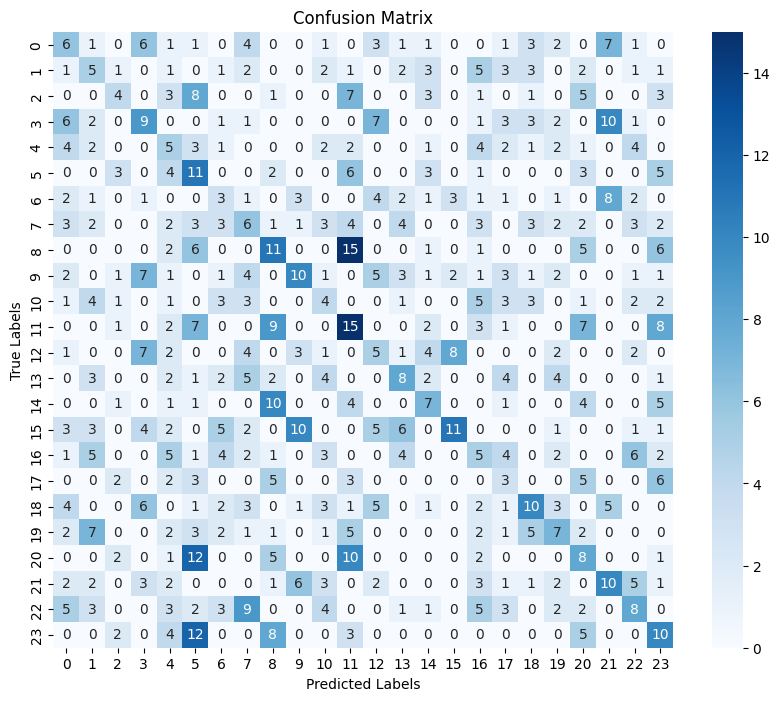

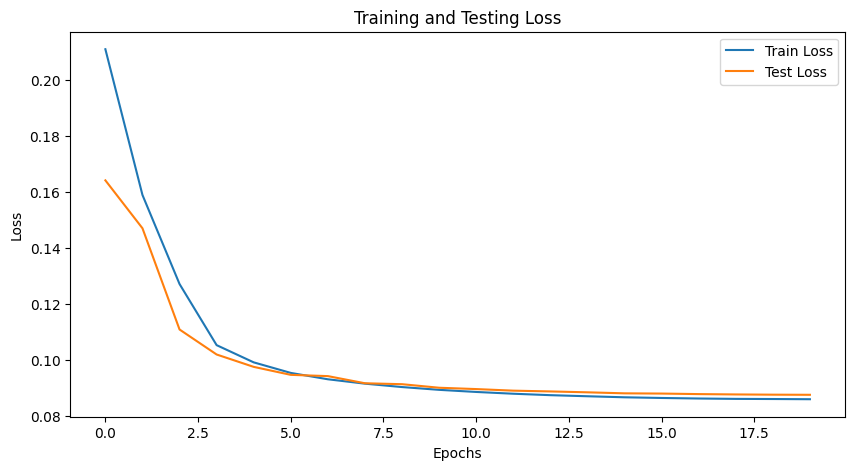

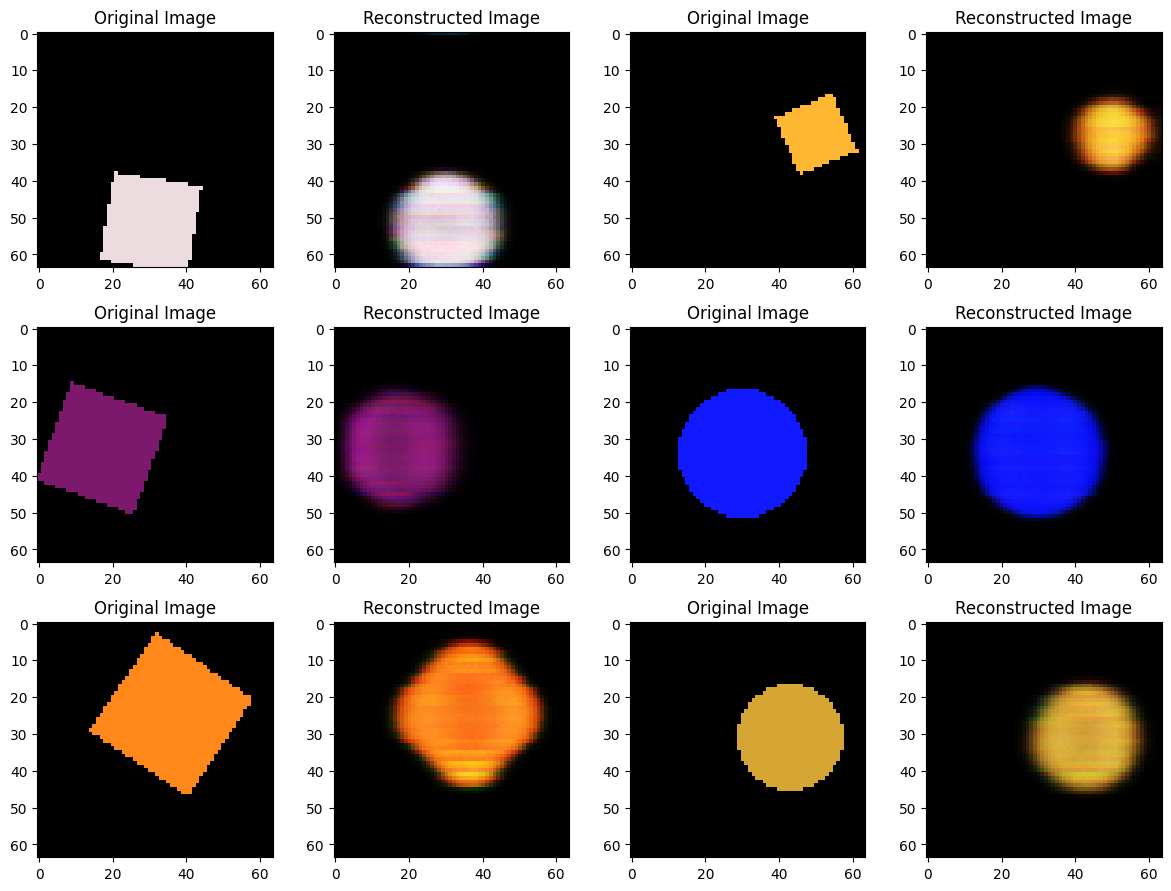

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (linear1): Linear(in_features=128, out_features=256, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=256, out_features=128, bias=True)
         (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=8192, out_features=16, bias=True)
   (decoder_input): Linear(in_features=16, out_features=8192

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 1641824
Epoch [1/20], Train Loss: 0.2065, Test Loss: 0.1639
Epoch [2/20], Train Loss: 0.1509, Test Loss: 0.1246
Epoch [3/20], Train Loss: 0.1092, Test Loss: 0.1047
Epoch [4/20], Train Loss: 0.0986, Test Loss: 0.0972
Epoch [5/20], Train Loss: 0.0937, Test Loss: 0.0937
Epoch [6/20], Train Loss: 0.0911, Test Loss: 0.0928
Epoch [7/20], Train Loss: 0.0893, Test Loss: 0.0903
Epoch [8/20], Train Loss: 0.0879, Test Loss: 0.0889
Epoch [9/20], Train Loss: 0.0866, Test Loss: 0.0881
Epoch [10/20], Train Loss: 0.0855, Test Loss: 0.0870
Epoch [11/20], Train Loss: 0.0846, Test Loss: 0.0863
Epoch [12/20], Train Loss: 0.0839, Test Loss: 0.0859
Epoch [13/20], Train Loss: 0.0834, Test Loss: 0.0856
Epoch [14/20], Train Loss: 0.0829, Test Loss: 0.0847
Epoch [15/20], Train Loss: 0.0824, Test Loss: 0.0844
Epoch [16/20], Train Loss: 0.0821, Test Loss: 0.0841
Epoch [17/20], Train Loss: 0.0818, Test Loss: 0.0839
Epoch [18/20], Train Loss: 0.0817, Test Loss: 0.0837
Epoch [19/20], Train Loss

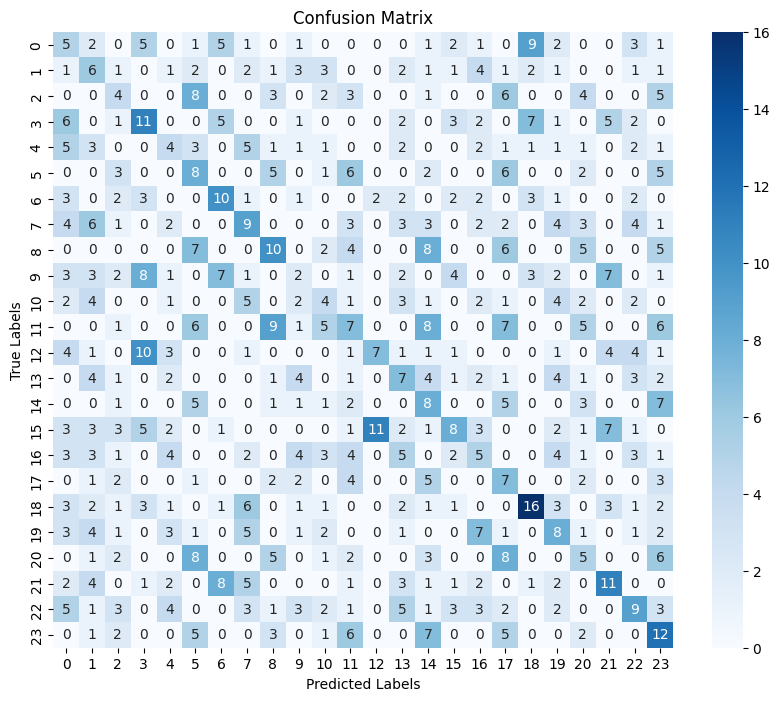

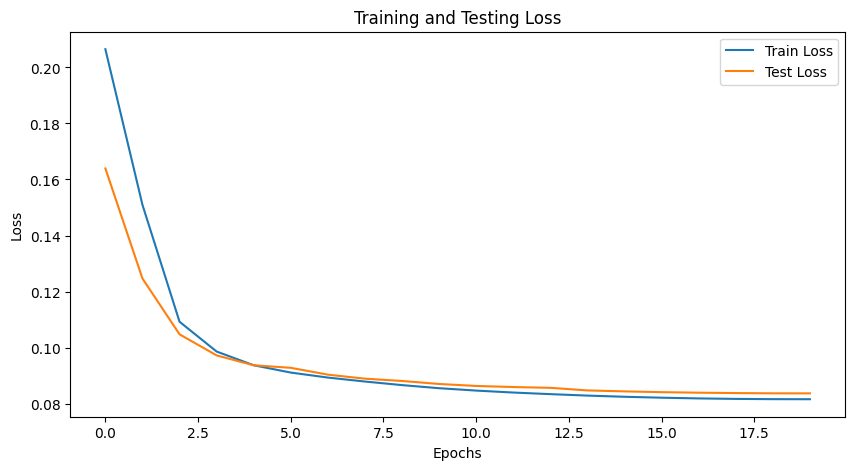

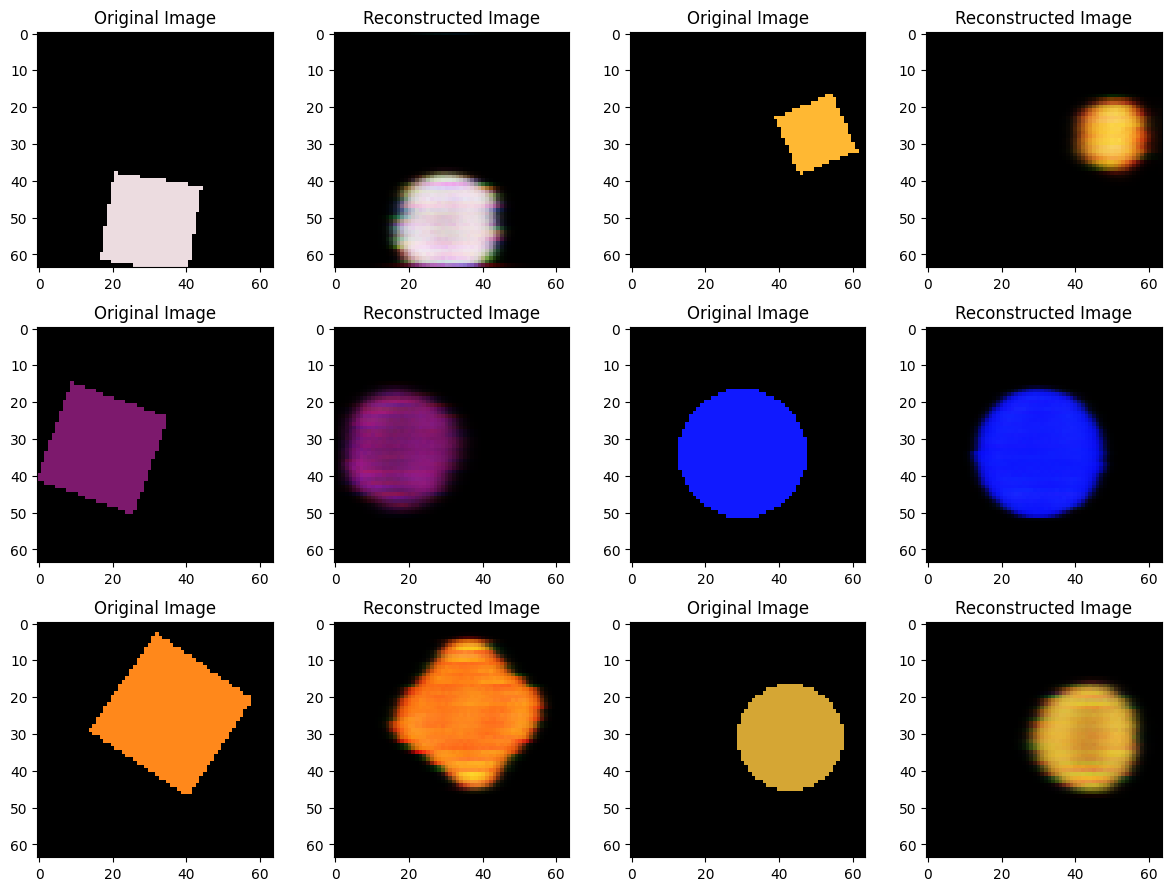

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (linear1): Linear(in_features=128, out_features=256, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=256, out_features=128, bias=True)
         (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=8192, out_features=32, bias=True)
   (decoder_input): Linear(in_features=32, out_features=8192

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 2166144
Epoch [1/20], Train Loss: 0.2042, Test Loss: 0.1622
Epoch [2/20], Train Loss: 0.1176, Test Loss: 0.1048
Epoch [3/20], Train Loss: 0.0980, Test Loss: 0.0965
Epoch [4/20], Train Loss: 0.0918, Test Loss: 0.0913
Epoch [5/20], Train Loss: 0.0881, Test Loss: 0.0885
Epoch [6/20], Train Loss: 0.0855, Test Loss: 0.0875
Epoch [7/20], Train Loss: 0.0834, Test Loss: 0.0846
Epoch [8/20], Train Loss: 0.0818, Test Loss: 0.0832
Epoch [9/20], Train Loss: 0.0804, Test Loss: 0.0823
Epoch [10/20], Train Loss: 0.0794, Test Loss: 0.0813
Epoch [11/20], Train Loss: 0.0787, Test Loss: 0.0807
Epoch [12/20], Train Loss: 0.0781, Test Loss: 0.0801
Epoch [13/20], Train Loss: 0.0776, Test Loss: 0.0799
Epoch [14/20], Train Loss: 0.0772, Test Loss: 0.0795
Epoch [15/20], Train Loss: 0.0769, Test Loss: 0.0792
Epoch [16/20], Train Loss: 0.0767, Test Loss: 0.0790
Epoch [17/20], Train Loss: 0.0765, Test Loss: 0.0788
Epoch [18/20], Train Loss: 0.0764, Test Loss: 0.0788
Epoch [19/20], Train Loss

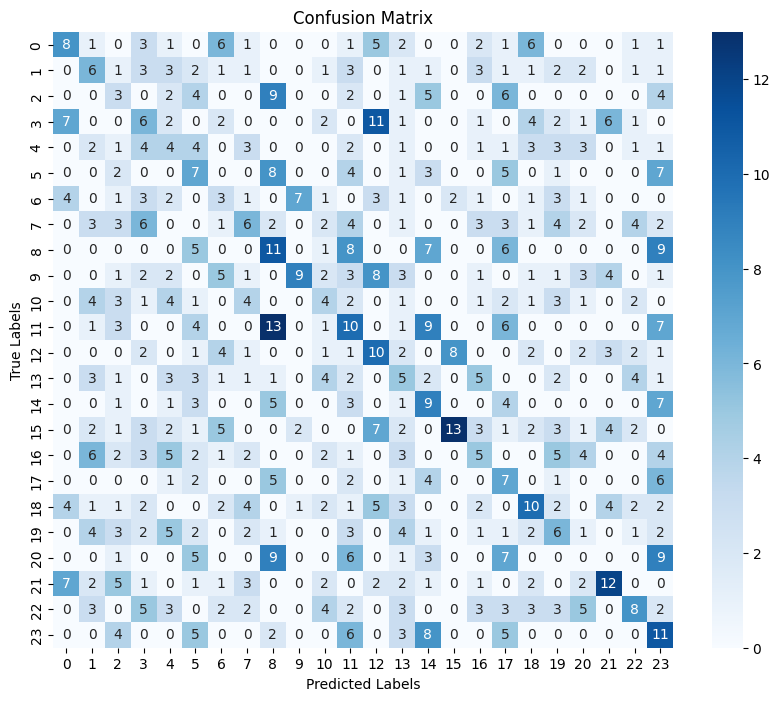

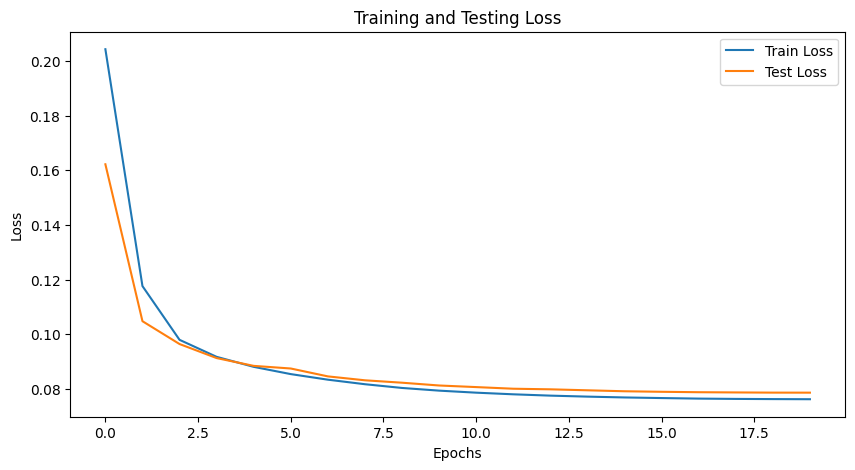

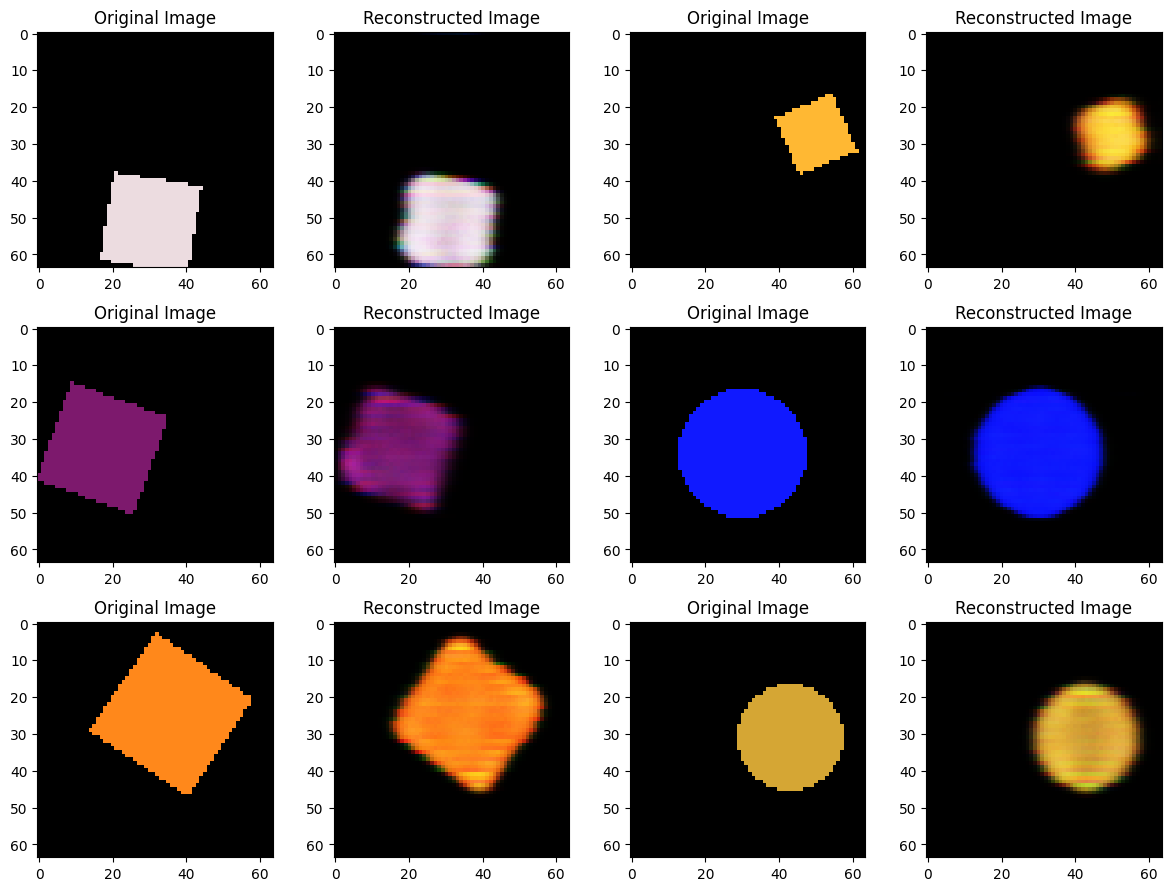

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (linear1): Linear(in_features=128, out_features=256, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=256, out_features=128, bias=True)
         (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=8192, out_features=64, bias=True)
   (decoder_input): Linear(in_features=64, out_features=8192

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)